In [1]:
from utils import conv
from utils import NN as nn
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# Load the saved weights
def load_weights(filename):
    with open(filename, 'rb') as f:
        data = np.load(f)
        weights_hidden_output = data['weights_hidden_output']
        bias_hidden_output = data['bias_hidden_output']
        weights_input_hidden = data['weights_input_hidden']
        bias_input_hidden = data['bias_input_hidden']
    return weights_hidden_output, bias_hidden_output, weights_input_hidden, bias_input_hidden

In [3]:
# Example kernels
sobel_h_kernel = np.array([[-1, -1, -1],
                           [ 0,  0,  0],
                           [ 1,  1,  1]])
sobel_v_kernel = sobel_h_kernel.T

sharp_kernel = np.array([[-1, -1, -1],
                         [-1,  9, -1],
                         [-1, -1, -1]])

smooth_kernel = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]])/9

gaussian_blur_kernel = np.array([[1/16, 1/8, 1/16],
                                 [1/8, 1/4, 1/8],
                                 [1/16, 1/8, 1/16]])

ori_gaussian_kernel = np.array([[21, 31, 21],
                                [31, 48, 31],
                                [21, 31, 21]])/256

gaussian_kernel = np.array([[21, 31, 21],
                            [31, 48, 31],
                            [21, 31, 21]])/200
gaussian_kernel = gaussian_kernel*1.05
# Define the list of kernels
kernel = [ori_gaussian_kernel]

In [4]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/feature_extract'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [5]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

In [5]:
# Prepare data
X_test, y_test = dp.prepare_data(image_test, image_label_test)
# Normalize the features
X__test_normalized = X_test / 255.0

In [6]:
# input_size = X__test_normalized.shape[0]
input_size = 3
hidden_size = 2  # hidden neuron
output_size = 2  # 2 classes: vegetation and non-vegetation

In [7]:
# Load weights for testing
weights_hidden_output, bias_hidden_output, weights_input_hidden, bias_input_hidden = load_weights('5. Bobot_skenario_5.npz')

# Initialize the neural network with the loaded weights
model_loaded = nn.NeuralNetwork(input_size, hidden_size, output_size)
model_loaded.weights_hidden_output = weights_hidden_output
model_loaded.bias_hidden_output = bias_hidden_output
model_loaded.weights_input_hidden = weights_input_hidden
model_loaded.bias_input_hidden = bias_input_hidden

In [18]:
print('Load Bobot dan bias optimal')
print('Bobot hidden-output:')
print(model_loaded.weights_hidden_output)
print('Bias hidden-output:')
print(model_loaded.bias_hidden_output[0][0])
print('Bobot input-hidden:')
print(model_loaded.weights_input_hidden)
print('Bias input-hidden:')
print(model_loaded.bias_input_hidden[0][0])

Load Bobot dan bias optimal
Bobot hidden-output:
[[-3.33070603  3.33070603]
 [ 0.92331358 -0.92331358]]
Bias hidden-output:
3.3468220972683174
Bobot input-hidden:
[[ 14.07420671 -29.67898771]
 [  7.3158213   43.46656037]
 [  1.30673026  26.4331599 ]]
Bias input-hidden:
2.5621966725500864


In [9]:
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives
TN = 0  # True Negatives

# Loop over testing images
for i in range(len(image_test)):
    TPi = 0  # True Positives index
    FPi = 0  # False Positives index
    FNi = 0  # False Negatives index
    TNi = 0  # True Negatives index

    input_image = image_test[i]
    ground_truth = image_label_test[i]

    # Preprocess the input image
    input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_reshaped.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Convert ground truth to binary mask for both vegetation and non-vegetation
    vegetation_ground_truth = np.logical_or(
        np.all(ground_truth == [0, 255, 255], axis=2),
        np.all(ground_truth == [0, 255, 0], axis=2)
    )
    
    # Calculate TP, FP, FN, TN for the current image
    for row in range(predicted_mask.shape[0]):
        for col in range(predicted_mask.shape[1]):
            if predicted_mask[row, col] == 1 and vegetation_ground_truth[row, col]:
                TPi += 1
                TP += 1
            elif predicted_mask[row, col] == 1 and not vegetation_ground_truth[row, col]:
                FPi += 1
                FP += 1
            elif predicted_mask[row, col] == 0 and vegetation_ground_truth[row, col]:
                FNi += 1
                FN += 1
            elif predicted_mask[row, col] == 0 and not vegetation_ground_truth[row, col]:
                TNi += 1
                TN += 1
    
    # Print the values for TP, FP, FN, TN for the current image
    print("Image {}: TP = {}, FP = {}, FN = {}, TN = {}".format(i+1, TPi, FPi, FNi, TNi))

Image 1: TP = 0, FP = 0, FN = 45, TN = 16339
Image 2: TP = 0, FP = 0, FN = 0, TN = 16384
Image 3: TP = 250, FP = 0, FN = 272, TN = 15862
Image 4: TP = 0, FP = 0, FN = 0, TN = 16384
Image 5: TP = 0, FP = 0, FN = 10, TN = 16374
Image 6: TP = 240, FP = 0, FN = 376, TN = 15768
Image 7: TP = 2615, FP = 0, FN = 2954, TN = 10815
Image 8: TP = 0, FP = 0, FN = 0, TN = 16384
Image 9: TP = 53, FP = 0, FN = 118, TN = 16213
Image 10: TP = 1837, FP = 0, FN = 7329, TN = 7218
Image 11: TP = 171, FP = 0, FN = 1493, TN = 14720
Image 12: TP = 2196, FP = 0, FN = 6735, TN = 7453
Image 13: TP = 19, FP = 0, FN = 207, TN = 16158
Image 14: TP = 154, FP = 34, FN = 243, TN = 15953
Image 15: TP = 2035, FP = 0, FN = 1014, TN = 13335
Image 16: TP = 0, FP = 0, FN = 0, TN = 16384
Image 17: TP = 0, FP = 0, FN = 0, TN = 16384
Image 18: TP = 0, FP = 0, FN = 0, TN = 16384
Image 19: TP = 0, FP = 0, FN = 0, TN = 16384
Image 20: TP = 0, FP = 0, FN = 0, TN = 16384
Image 21: TP = 14, FP = 0, FN = 201, TN = 16169
Image 22: TP 

In [10]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1_score = 2 * (precision * recall) / (precision + recall)
IoU = TP / (TP + FP + FN)

print('TP:', TP)
print('FP:', FP)
print('FN:', FN)
print('TN:', TN)

print()
print('Recall: {:.3f}'.format(recall))
print('Precision: {:.3f}'.format(precision))
print('Accuracy: {:.3f}'.format(accuracy))
print('F1 Score: {:.3f}'.format(f1_score))

print()
print("IoU Overall: {:.3f} ".format(IoU))

TP: 1928021
FP: 5646
FN: 2574951
TN: 7894070

Recall: 0.428
Precision: 0.997
Accuracy: 0.792
F1 Score: 0.599

IoU Overall: 0.428 


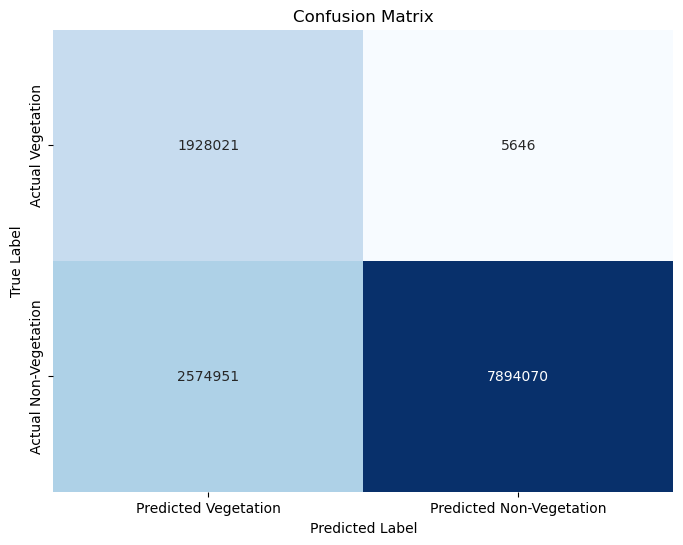

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Vegetation', 'Predicted Non-Vegetation'], 
            yticklabels=['Actual Vegetation', 'Actual Non-Vegetation'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Initialize lists for TP, FP, FN, and IoU
TP_vegetation = []
FP_vegetation = []
FN_vegetation = []
IoU_vegetation = []

TP_non_vegetation = []
FP_non_vegetation = []
FN_non_vegetation = []
IoU_non_vegetation = []

# Loop over testing images
for i in range(len(image_test)):
    input_image = image_test[i]
    ground_truth = image_label_test[i]

    # Preprocess the input image
    input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_reshaped.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Convert ground truth to binary mask for both vegetation and non-vegetation
    vegetation_ground_truth = np.logical_or(
        np.all(ground_truth == [0, 255, 255], axis=2),
        np.all(ground_truth == [0, 255, 0], axis=2)
    )
    
    # Calculate TP, FP, FN counts for both vegetation and non-vegetation classes
    TP_veg = np.sum(np.logical_and(vegetation_ground_truth, predicted_mask))
    FP_veg = np.sum(predicted_mask & ~vegetation_ground_truth)
    FN_veg = np.sum(vegetation_ground_truth & ~predicted_mask)
    
    TP_non_veg = np.sum(np.logical_and(~vegetation_ground_truth, ~predicted_mask))
    FP_non_veg = np.sum(np.logical_and(~vegetation_ground_truth, predicted_mask))
    FN_non_veg = np.sum(np.logical_and(vegetation_ground_truth, ~predicted_mask))

    # Append TP, FP, FN counts for vegetation and non-vegetation classes
    TP_vegetation.append(TP_veg)
    FP_vegetation.append(FP_veg)
    FN_vegetation.append(FN_veg)
    
    TP_non_vegetation.append(TP_non_veg)
    FP_non_vegetation.append(FP_non_veg)
    FN_non_vegetation.append(FN_non_veg)

    # Calculate IoU for vegetation and non-vegetation classes if the denominator is not zero
    denominator_veg = TP_veg + FP_veg + FN_veg
    denominator_non_veg = TP_non_veg + FP_non_veg + FN_non_veg

    IoU_vegetation.append(TP_veg / denominator_veg if denominator_veg != 0 else 0.0)
    IoU_non_vegetation.append(TP_non_veg / denominator_non_veg if denominator_non_veg != 0 else 0.0)

    # print("Image {}: Vegetation IoU: {:.4f}, Non-Vegetation IoU: {:.4f}".format(i+1, IoU_vegetation[-1], IoU_non_vegetation[-1]))
    print("Image {}:".format(i+1))
    print("TP_veg: {}, FP_veg: {}, FN_veg: {}, IoU_veg: {:.4f}".format(TP_veg, FP_veg, FN_veg, IoU_vegetation[-1]))
    print("TP_non_veg: {}, FP_non_veg: {}, FN_non_veg: {}, IoU_non_veg: {:.4f}".format(TP_non_veg, FP_non_veg, FN_non_veg, IoU_non_vegetation[-1]))

Image 1:
TP_veg: 0, FP_veg: 0, FN_veg: 45, IoU_veg: 0.0000
TP_non_veg: 16339, FP_non_veg: 0, FN_non_veg: 45, IoU_non_veg: 0.9973
Image 2:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_veg: 0, FN_non_veg: 0, IoU_non_veg: 1.0000
Image 3:
TP_veg: 250, FP_veg: 0, FN_veg: 272, IoU_veg: 0.4789
TP_non_veg: 15862, FP_non_veg: 0, FN_non_veg: 522, IoU_non_veg: 0.9681
Image 4:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_veg: 0, FN_non_veg: 0, IoU_non_veg: 1.0000
Image 5:
TP_veg: 0, FP_veg: 0, FN_veg: 10, IoU_veg: 0.0000
TP_non_veg: 16374, FP_non_veg: 0, FN_non_veg: 10, IoU_non_veg: 0.9994
Image 6:
TP_veg: 240, FP_veg: 0, FN_veg: 376, IoU_veg: 0.3896
TP_non_veg: 15768, FP_non_veg: 0, FN_non_veg: 616, IoU_non_veg: 0.9624
Image 7:
TP_veg: 2615, FP_veg: 0, FN_veg: 2954, IoU_veg: 0.4696
TP_non_veg: 10815, FP_non_veg: 0, FN_non_veg: 5569, IoU_non_veg: 0.6601
Image 8:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_ve

In [10]:
# mean_iou_vegetation = np.mean(IoU_vegetation)
# mean_iou_non_vegetation = np.mean(IoU_non_vegetation)
# mean_all_iou = (mean_iou_vegetation + mean_iou_non_vegetation) / 2
# print("Mean IoU for Vegetation Class: {:.2f}".format(mean_iou_vegetation * 100), "%")
# print("Mean IoU for Non-Vegetation Class: {:.2f}".format(mean_iou_non_vegetation * 100), "%")
# print("Mean IoU Overall: {:.2f}".format(mean_all_iou * 100), "%")

In [11]:
tp_veg_overall = np.sum(TP_vegetation)
fp_veg_overall = np.sum(FP_vegetation)
fn_veg_overall = np.sum(FN_vegetation)

print("TP Vegetation: ", tp_veg_overall)
print("FP Vegetation: ", fp_veg_overall)
print("FN Vegetation: ", fn_veg_overall)

IoU_veg_overall = tp_veg_overall / (tp_veg_overall + fp_veg_overall + fn_veg_overall)
print("IoU Vegetation: ", IoU_veg_overall)

tp_non_veg_overall = np.sum(TP_non_vegetation)
fp_non_veg_overall = np.sum(FP_non_vegetation)
fn_non_veg_overall = np.sum(FN_non_vegetation)

print("\nTP Non-Vegetation: ", tp_non_veg_overall)
print("FP Non-Vegetation: ", fp_non_veg_overall)
print("FN Non-Vegetation: ", fn_non_veg_overall)

IoU_non_veg_overall = tp_non_veg_overall / (tp_non_veg_overall + fp_non_veg_overall + fn_non_veg_overall)
print("IoU Non-Vegetation: ", IoU_non_veg_overall)

IoU_overall = (IoU_veg_overall + IoU_non_veg_overall)/2
print("\nIoU Overall: ", IoU_overall)

TP Vegetation:  1928021
FP Vegetation:  5646
FN Vegetation:  2574951
IoU Vegetation:  0.42763015185584585

TP Non-Vegetation:  7899716
FP Non-Vegetation:  5646
FN Non-Vegetation:  4502972
IoU Non-Vegetation:  0.6366459832560922

IoU Overall:  0.532138067555969


========================================================================================================

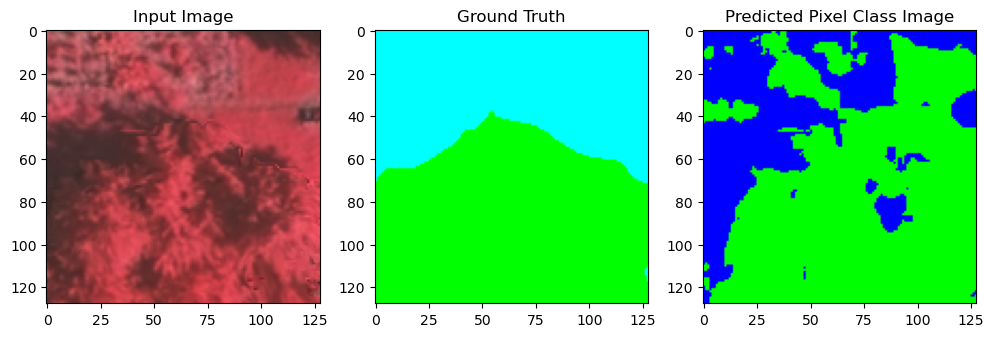

In [207]:
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255] # Blue

# 5, 1506, 1602, 1813
indexing = 1602
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Visualize input image, ground truth, and segmented image
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

# print("IoU Vegetation: {:.4f}".format(IoU_vegetation[indexing]))
# print("IoU Non-Vegetation: {:.4f}".format(IoU_non_vegetation[indexing]))
# print("Mean IoU: {:.4f}".format((IoU_vegetation[indexing] + IoU_non_vegetation[indexing])/2))
plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
# IoU = (IoU_vegetation[indexing] + IoU_non_vegetation[indexing]) / 2
plt.title('Predicted Pixel Class Image')

plt.show()

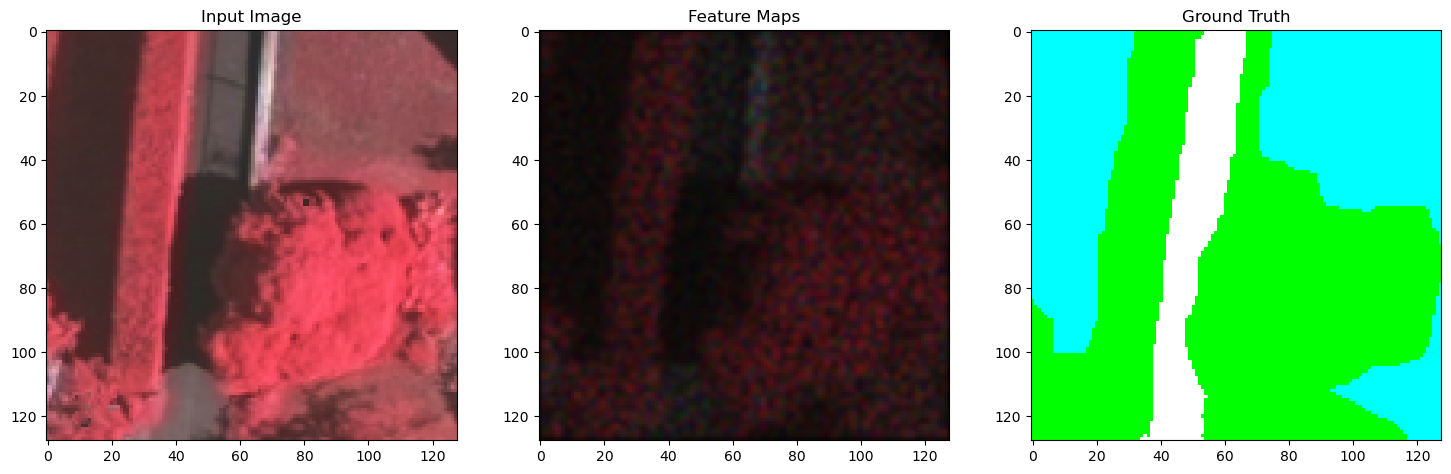

Pixel Class -> [0 255 0] = vegetation, [0 0 255] = non-vegetation
Coordinates (x, y):				(40, 127)
Input Image Pixel Value:			[18 11 17]
Prediction Values (non-vegetation, vegetation):	[0.93943656 0.06056344]
Class Prediction Image Pixel:			[  0   0 255]
Ground Truth Pixel Value:			[255 255 255]


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define colors for segmentation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# 5, 1506, 1602, 1813
# Index for the current image
indexing = 5
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)

# Predict segmentation mask and capture the last layer's output
output_logits = model_loaded.forward(features)
predicted_mask = output_logits.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Visualize input image, ground truth, and segmented image
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

# plt.subplot(1, 3, 3)
# plt.imshow(segmented_image)
# plt.title('Predicted Pixel Class Image')

plt.show()

# Function to compare pixel values at specific coordinates and the raw prediction values
def compare_pixels(x, y):
    input_pixel = features_get[y, x]
    ground_truth_pixel = ground_truth[y, x]
    segmented_pixel = segmented_image[y, x]
    raw_prediction = output_logits[y * 128 + x]  # Get the raw prediction values

    print("Pixel Class -> [0 255 0] = vegetation, [0 0 255] = non-vegetation")
    print(f"Coordinates (x, y):\t\t\t\t({x}, {y})")
    print(f"Input Image Pixel Value:\t\t\t{input_pixel}")
    print(f"Prediction Values (non-vegetation, vegetation):\t{raw_prediction}")
    print(f"Class Prediction Image Pixel:\t\t\t{segmented_pixel}")
    print(f"Ground Truth Pixel Value:\t\t\t{ground_truth_pixel}")
    

# Example coordinates to compare
x, y = 40,127   # Change this to any coordinate you want to check
compare_pixels(x, y)

Indeks Piksel (0, 10)
Red:	 [12 20 23 24 21 18 14 12 11 10]
Green:	 [6 8 8 7 7 7 7 7 7 6]
Blue:	 [6 9 9 9 9 9 8 6 4 3]


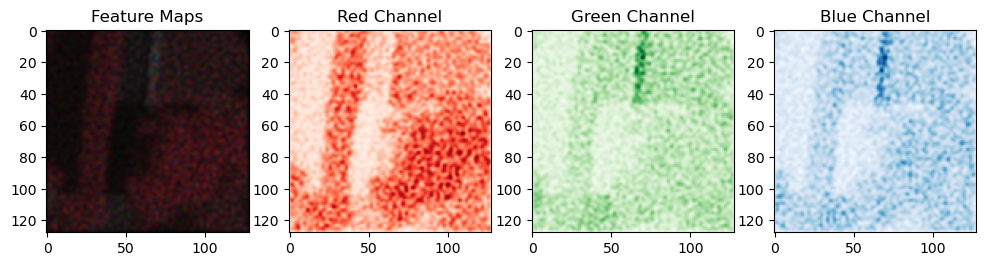

In [9]:
# Split the image into its RGB channels
r, g, b = cv2.split(features_get)

# Visualize the RGB channels
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(1, 4, 2)
plt.imshow(r, cmap='Reds')
plt.title('Red Channel')

plt.subplot(1, 4, 3)
plt.imshow(g, cmap='Greens')
plt.title('Green Channel')

plt.subplot(1, 4, 4)
plt.imshow(b, cmap='Blues')
plt.title('Blue Channel')

# plt.show()
print("Indeks Piksel (0, 10)")
print("Red:\t", r[0][0:10])
print("Green:\t", g[0][0:10])
print("Blue:\t", b[0][0:10])

Total Pixels: 16384
Total vegetation pixels: 8819
Total non-vegetation pixels: 7565
Predicted Image:
Total Pixels: 16384
Total vegetation pixels: 4522
Total non-vegetation pixels: 11862


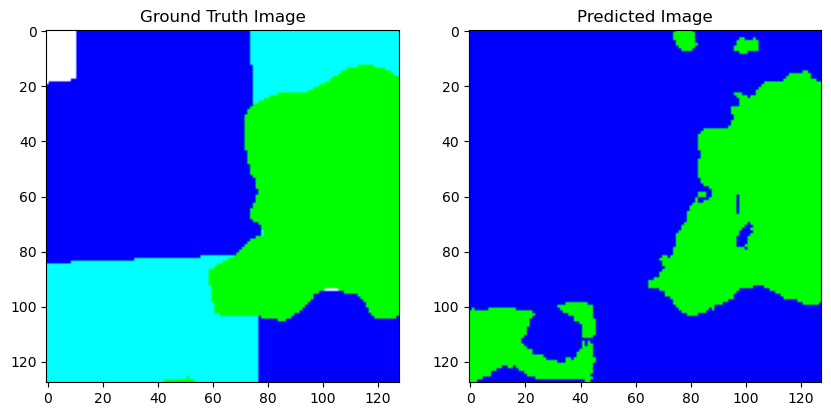

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# 5, 1506, 1602, 1813
# Load the ground truth image
index = 1506
input_image = images_load[index]
ground_truth = ground_truths[index]
features_get = fe.extract(input_image)
ground_truth_image = ground_truth

# Initialize counters
vegetation_count = 0
non_vegetation_count = 0

# Check each pixel in the ground truth image
for y in range(ground_truth_image.shape[0]):
    for x in range(ground_truth_image.shape[1]):
        pixel = ground_truth_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count += 1

# Print the results
print("Total Pixels:", vegetation_count + non_vegetation_count)
print(f"Total vegetation pixels: {vegetation_count}")
print(f"Total non-vegetation pixels: {non_vegetation_count}")

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Load the predicted image (assuming you have it as 'predicted_image')
predicted_image = segmented_image  # Replace with actual predicted image

# Initialize counters for predicted image
vegetation_count_pred = 0
non_vegetation_count_pred = 0

# Check each pixel in the predicted image
for y in range(predicted_image.shape[0]):
    for x in range(predicted_image.shape[1]):
        pixel = predicted_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_pred += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_pred += 1

# Print the predicted results
print("Predicted Image:")
print("Total Pixels:", vegetation_count_pred + non_vegetation_count_pred)
print(f"Total vegetation pixels: {vegetation_count_pred}")
print(f"Total non-vegetation pixels: {non_vegetation_count_pred}")

# Optionally, visualize the ground truth and predicted images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_image)
plt.title('Ground Truth Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted Image')

plt.show()

Ground Truth:
Total Pixels: 16384
Total vegetation pixels: 9250
Total non-vegetation pixels: 7134
Predicted Image:
Total Pixels: 16384
Total vegetation pixels: 5923
Total non-vegetation pixels: 10461

Comparison:
Difference in vegetation pixels: -3327
Difference in non-vegetation pixels: 3327


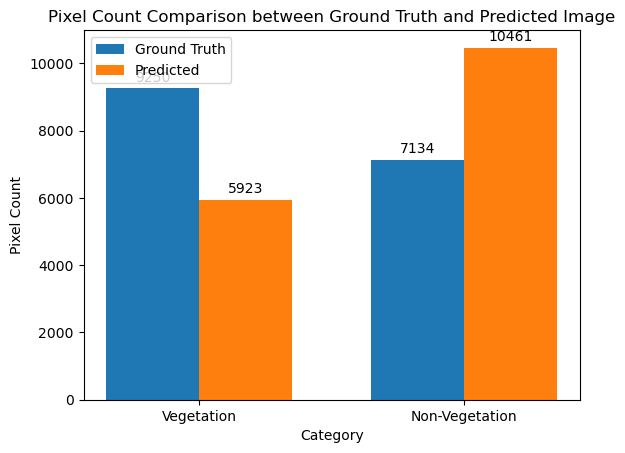

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# Example indices
indices = [5, 1506, 1602, 1813]

# Select the index
index = 1813

# Load the input image and ground truth
input_image = images_load[index]
ground_truth = ground_truths[index]

# Extract features
features_get = fe.extract(input_image)

# Initialize counters for the ground truth image
vegetation_count_gt = 0
non_vegetation_count_gt = 0

# Check each pixel in the ground truth image
for y in range(ground_truth.shape[0]):
    for x in range(ground_truth.shape[1]):
        pixel = ground_truth[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_gt += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_gt += 1

# Print the ground truth results
print("Ground Truth:")
print("Total Pixels:", vegetation_count_gt + non_vegetation_count_gt)
print(f"Total vegetation pixels: {vegetation_count_gt}")
print(f"Total non-vegetation pixels: {non_vegetation_count_gt}")

# Preprocess the input image for the model
input_image_resized = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_resized.reshape(-1, 3)

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)
segmented_image[predicted_mask == 0] = non_vegetation_colors[0]  # Assuming non-vegetation class 0
segmented_image[predicted_mask == 1] = vegetation_colors[0]  # Assuming vegetation class 1

# Initialize counters for the predicted image
vegetation_count_pred = 0
non_vegetation_count_pred = 0

# Check each pixel in the predicted image
for y in range(segmented_image.shape[0]):
    for x in range(segmented_image.shape[1]):
        pixel = segmented_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_pred += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_pred += 1

# Print the predicted results
print("Predicted Image:")
print("Total Pixels:", vegetation_count_pred + non_vegetation_count_pred)
print(f"Total vegetation pixels: {vegetation_count_pred}")
print(f"Total non-vegetation pixels: {non_vegetation_count_pred}")

# Compare the results
print("\nComparison:")
print(f"Difference in vegetation pixels: {vegetation_count_pred - vegetation_count_gt}")
print(f"Difference in non-vegetation pixels: {non_vegetation_count_pred - non_vegetation_count_gt}")

# Visualization
categories = ['Vegetation', 'Non-Vegetation']
ground_truth_counts = [vegetation_count_gt, non_vegetation_count_gt]
predicted_counts = [vegetation_count_pred, non_vegetation_count_pred]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, ground_truth_counts, width, label='Ground Truth')
bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Category')
ax.set_ylabel('Pixel Count')
ax.set_title('Pixel Count Comparison between Ground Truth and Predicted Image')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/feature_extract'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# Initialize total counters for ground truth and predicted images
total_vegetation_count_gt = 0
total_non_vegetation_count_gt = 0
total_vegetation_count_pred = 0
total_non_vegetation_count_pred = 0

# Iterate through all images
for index in range(len(images_load)):
    # Load the input image and ground truth
    input_image = images_load[index]
    ground_truth = ground_truths[index]

    # Extract features
    features_get = fe.extract(input_image)

    # Initialize counters for the ground truth image
    vegetation_count_gt = 0
    non_vegetation_count_gt = 0

    # Check each pixel in the ground truth image
    for y in range(ground_truth.shape[0]):
        for x in range(ground_truth.shape[1]):
            pixel = ground_truth[y, x]
            if any(np.array_equal(pixel, color) for color in vegetation_colors):
                vegetation_count_gt += 1
            elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
                non_vegetation_count_gt += 1

    # Add to total counts
    total_vegetation_count_gt += vegetation_count_gt
    total_non_vegetation_count_gt += non_vegetation_count_gt

    # Preprocess the input image for the model
    input_image_resized = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_resized.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Create segmented image
    segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)
    segmented_image[predicted_mask == 0] = non_vegetation_colors[0]  # Assuming non-vegetation class 0
    segmented_image[predicted_mask == 1] = vegetation_colors[0]  # Assuming vegetation class 1

    # Initialize counters for the predicted image
    vegetation_count_pred = 0
    non_vegetation_count_pred = 0

    # Check each pixel in the predicted image
    for y in range(segmented_image.shape[0]):
        for x in range(segmented_image.shape[1]):
            pixel = segmented_image[y, x]
            if any(np.array_equal(pixel, color) for color in vegetation_colors):
                vegetation_count_pred += 1
            elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
                non_vegetation_count_pred += 1

    # Add to total counts
    total_vegetation_count_pred += vegetation_count_pred
    total_non_vegetation_count_pred += non_vegetation_count_pred

# Calculate total pixels in ground truth and predicted images
total_pixels_gt = total_vegetation_count_gt + total_non_vegetation_count_gt
total_pixels_pred = total_vegetation_count_pred + total_non_vegetation_count_pred

# Calculate distribution percentages
vegetation_percentage_gt = (total_vegetation_count_gt / total_pixels_gt) * 100
non_vegetation_percentage_gt = (total_non_vegetation_count_gt / total_pixels_gt) * 100
vegetation_percentage_pred = (total_vegetation_count_pred / total_pixels_pred) * 100
non_vegetation_percentage_pred = (total_non_vegetation_count_pred / total_pixels_pred) * 100

# Print the total results
print("Ground Truth:")
print("Total Pixels:", total_pixels_gt)
print(f"Total vegetation pixels: {total_vegetation_count_gt} ({vegetation_percentage_gt:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_gt} ({non_vegetation_percentage_gt:.2f}%)")

print("Predicted Image:")
print("Total Pixels:", total_pixels_pred)
print(f"Total vegetation pixels: {total_vegetation_count_pred} ({vegetation_percentage_pred:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_pred} ({non_vegetation_percentage_pred:.2f}%)")

Ground Truth:
Total Pixels: 41385984
Total vegetation pixels: 17036636 (41.17%)
Total non-vegetation pixels: 24349348 (58.83%)
Predicted Image:
Total Pixels: 41385984
Total vegetation pixels: 7861678 (19.00%)
Total non-vegetation pixels: 33524306 (81.00%)


Ground Truth:
Total Pixels: 41385984
Total vegetation pixels: 17036636 (41.17%)
Total non-vegetation pixels: 24349348 (58.83%)
Predicted Image:
Total Pixels: 41385984
Total vegetation pixels: 7861678 (19.00%)
Total non-vegetation pixels: 33524306 (81.00%)


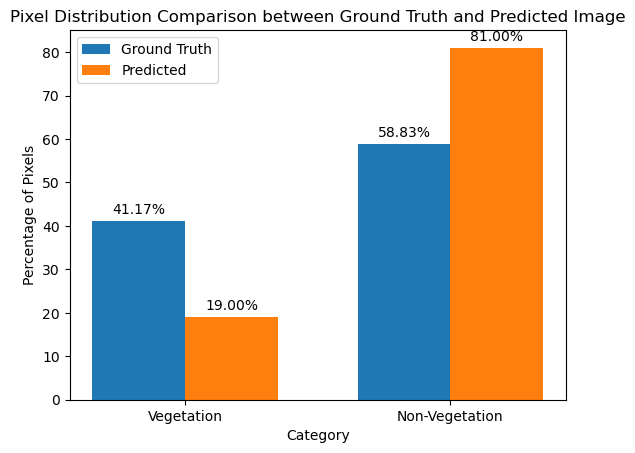

In [216]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the previous calculations
total_pixels_gt = 41385984
total_vegetation_count_gt = 17036636
total_non_vegetation_count_gt = 24349348
vegetation_percentage_gt = (total_vegetation_count_gt / total_pixels_gt) * 100
non_vegetation_percentage_gt = (total_non_vegetation_count_gt / total_pixels_gt) * 100

total_pixels_pred = 41385984
total_vegetation_count_pred = 7861678
total_non_vegetation_count_pred = 33524306
vegetation_percentage_pred = (total_vegetation_count_pred / total_pixels_pred) * 100
non_vegetation_percentage_pred = (total_non_vegetation_count_pred / total_pixels_pred) * 100

# Print the total results
print("Ground Truth:")
print("Total Pixels:", total_pixels_gt)
print(f"Total vegetation pixels: {total_vegetation_count_gt} ({vegetation_percentage_gt:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_gt} ({non_vegetation_percentage_gt:.2f}%)")

print("Predicted Image:")
print("Total Pixels:", total_pixels_pred)
print(f"Total vegetation pixels: {total_vegetation_count_pred} ({vegetation_percentage_pred:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_pred} ({non_vegetation_percentage_pred:.2f}%)")

# Visualization
categories = ['Vegetation', 'Non-Vegetation']
ground_truth_counts = [vegetation_percentage_gt, non_vegetation_percentage_gt]
predicted_counts = [vegetation_percentage_pred, non_vegetation_percentage_pred]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, ground_truth_counts, width, label='Ground Truth')
bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Category')
ax.set_ylabel('Percentage of Pixels')
ax.set_title('Pixel Distribution Comparison between Ground Truth and Predicted Image')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [120]:
# # Function to compare pixel values at specific coordinates and the raw prediction values
# def compare_pixels(x, y):
#     input_pixel = input_image[y, x]
#     ground_truth_pixel = ground_truth[y, x]
#     segmented_pixel = segmented_image[y, x]
#     raw_prediction = output_logits[y * 128 + x]  # Get the raw prediction values

#     print("Pixel Class -> [0 255 0] = vegetation, [0 0 255] = non-vegetation")
#     print(f"Coordinates (x, y):\t\t\t\t({x}, {y})")
#     print(f"Input Image Pixel Value:\t\t\t{input_pixel}")
#     print(f"Prediction Values (non-vegetation, vegetation):\t{raw_prediction}")
#     print(f"Class Prediction Image Pixel:\t\t\t{segmented_pixel}")
#     print(f"Ground Truth Pixel Value:\t\t\t{ground_truth_pixel}")

# # Iterate over each pixel in the 128x128 image
# for y in range(128):
#     for x in range(128):
#         compare_pixels(x, y)